In [1]:
library(rstatix)
library(readr)
# library(lme4)
library(afex)
library(performance)
library(RCurl)
library(optimx)
library(parallel)
library(minqa)
library(ggpubr)
library(ez) 
# https://github.com/mike-lawrence/ez

Warning message:
“package ‘rstatix’ was built under R version 4.0.3”

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘afex’ was built under R version 4.0.5”
Loading required package: lme4

Warning message:
“package ‘lme4’ was built under R version 4.0.5”
Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.0.5”
************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: emmeans() for ANOVA models now uses model = 'multivariate' as default.
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()


In [2]:
df = read_csv("../clean_data/forced_choice_emotion_uw_students_long_format_lmer.csv")


── Column specification ──────────────────────────────────────────────────────────────────────────────────────
cols(
  participantId = col_double(),
  photoId = col_character(),
  emotion = col_character(),
  ethnicity = col_character(),
  sex = col_character(),
  age = col_character(),
  label = col_character(),
  url = col_character(),
  sentimentScore = col_double(),
  sexC = col_double(),
  ageC = col_double(),
  ethnicityC = col_double()
)




# LMER

## Run model with Nelder-Mead opt

In [4]:
lmer_fc_uw = lmer(sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), data = df, REML = FALSE, 
          control = lmerControl(optimizer ="Nelder_Mead"))
summary(lmer_fc_uw)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0833579 (tol = 0.002, component 1)”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId)
   Data: df
Control: lmerControl(optimizer = "Nelder_Mead")

     AIC      BIC   logLik deviance df.resid 
 10453.6  10561.5  -5211.8  10423.6     9777 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2719 -0.9327  0.1997  0.9007  1.7652 

Random effects:
 Groups        Name            Variance  Std.Dev.  Corr             
 participantId (Intercept)     5.006e-04 0.0223734                  
               sexC            1.391e-06 0.0011792 -1.00            
               ethnicityC      7.550e-07 0.0008689 -0.99  0.99      
               sexC:ethnicityC 6.703e-06 0.0025890  0.86 -0.86 -0.84
 Residual                      1.694e-01 0.4115362                  
Number of obs: 9792, groups:  participantId, 51

Fixed effects:
                  Estimate Std. Error         df t v

## Check collinearity

In [5]:
check_collinearity(lmer_fc_uw)

,Term,VIF,SE_factor
,<chr>,<dbl>,<dbl>
1,sexC,1,1
2,ethnicityC,1,1
3,sexC:ethnicityC,1,1


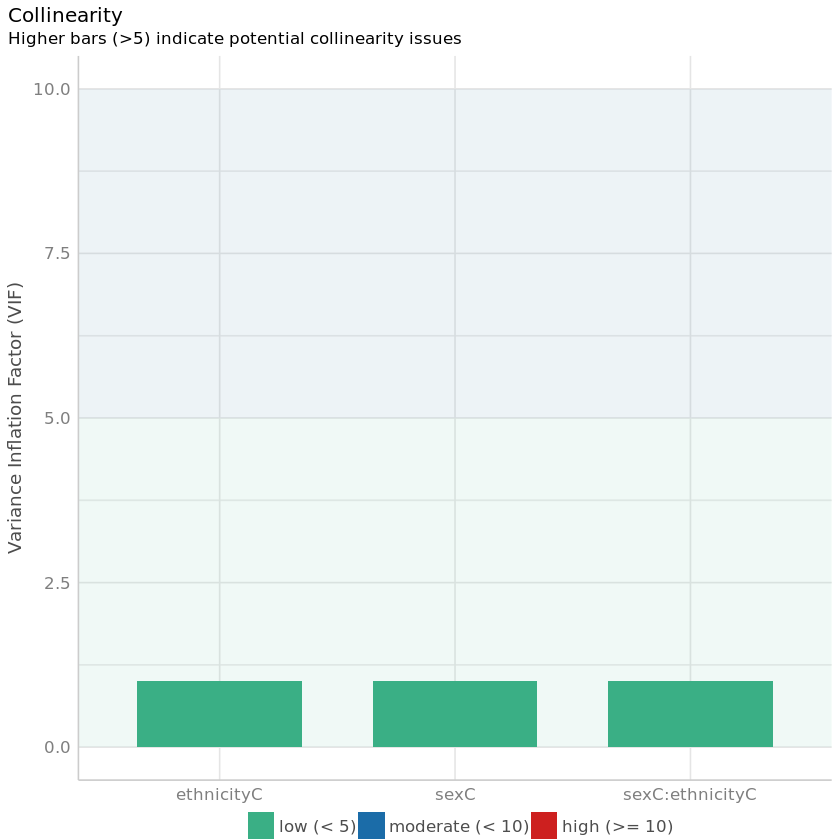

In [6]:
plot(check_collinearity(lmer_fc_uw))

## Check singularity

In [7]:
# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
tt = getME(lmer_fc_uw,"theta")
ll = getME(lmer_fc_uw,"lower")
tt_value = min(tt[ll==0])
tt_value

[1] 0.000128365

In [8]:
tt_value < 0.000001
# not a problem, problably a false positive

[1] FALSE

In [100]:
theta <- getME(lmer_fc_uw,"theta")
## diagonal elements are identifiable because they are fitted
##  with a lower bound of zero ...
diag.element <- getME(lmer_fc_uw,"lower")==0
any(theta[diag.element]<1e-5)

[1] FALSE

## Testing multiple optimizers


In [10]:
lmer_fc_uw_m = lmer(sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), data = df)

boundary (singular) fit: see ?isSingular



In [11]:
ncores <- detectCores()
diff_optims <- allFit(lmer_fc_uw_m, maxfun = 1e5, parallel = 'multicore', ncpus = ncores)

Loading required namespace: dfoptim



In [12]:
is.OK <- sapply(diff_optims, is, "merMod")
diff_optims.OK <- diff_optims[is.OK]
lapply(diff_optims.OK,function(x) x@optinfo$conv$lme4$messages)

$bobyqa
[1] "boundary (singular) fit: see ?isSingular"

$Nelder_Mead
[1] "boundary (singular) fit: see ?isSingular"

$nlminbwrap
[1] "boundary (singular) fit: see ?isSingular"

$`optimx.L-BFGS-B`
[1] "boundary (singular) fit: see ?isSingular"

$nloptwrap.NLOPT_LN_NELDERMEAD
[1] "boundary (singular) fit: see ?isSingular"

$nloptwrap.NLOPT_LN_BOBYQA
[1] "boundary (singular) fit: see ?isSingular"

In [13]:
(lliks <- sort(sapply(diff_optims.OK,logLik)))

Nelder_Mead     nloptwrap.NLOPT_LN_BOBYQA 
                    -5227.068                     -5227.068 
              optimx.L-BFGS-B nloptwrap.NLOPT_LN_NELDERMEAD 
                    -5227.068                     -5227.068 
                       bobyqa                    nlminbwrap 
                    -5227.068                     -5227.068

# Three-way Anova

## Descriptives

In [17]:
df %>%
  group_by(ethnicity, sex, age) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicity,sex,age,variable,n,mean,sd
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,1224,-0.134,0.417
bipoc,female,child,sentimentScore,1224,-0.089,0.418
bipoc,male,adult,sentimentScore,1224,-0.175,0.406
bipoc,male,child,sentimentScore,1224,-0.121,0.416
white,female,adult,sentimentScore,1224,-0.118,0.410
white,female,child,sentimentScore,1224,-0.089,0.412
white,male,adult,sentimentScore,1224,-0.094,0.395
white,male,child,sentimentScore,1224,-0.104,0.420


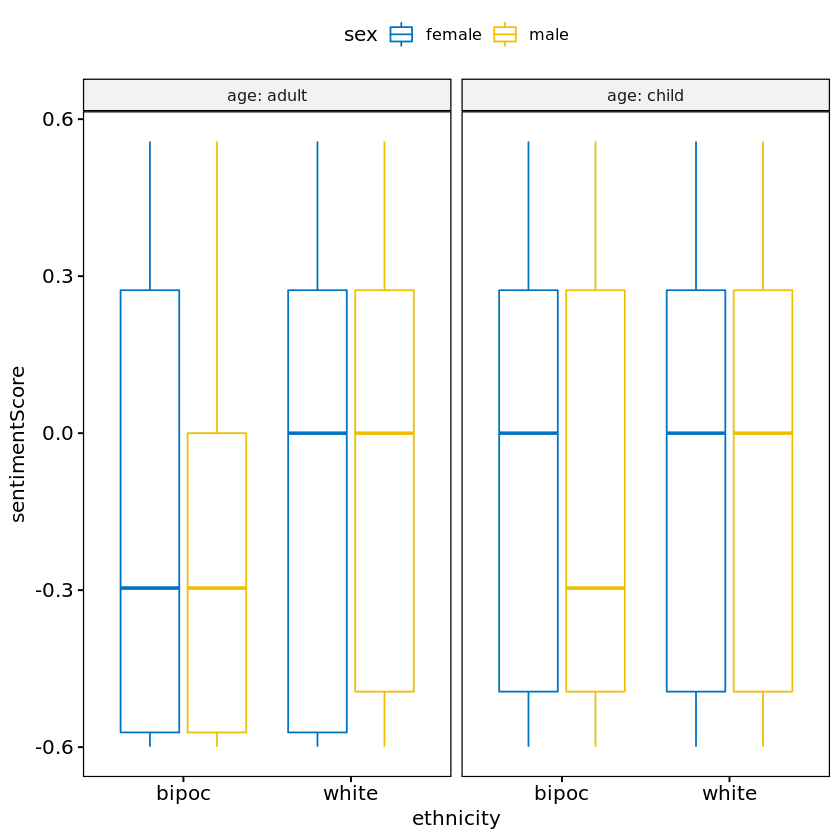

In [14]:
bxp <- ggboxplot(
  df, x = "ethnicity", y = "sentimentScore",
  color = "sex", palette = "jco",
  facet.by = "age", short.panel.labs = FALSE
  )
bxp

## Check assumptions

### Outliers

In [16]:
df %>% group_by(ethnicity, sex, age) %>% identify_outliers(sentimentScore)

ethnicity,sex,age,participantId,photoId,emotion,label,url,sentimentScore,sexC,ageC,ethnicityC,is.outlier,is.extreme
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>


### Normality assumption

In [18]:
# Compute Shapiro-Wilk test for each combinations of factor levels

df %>%
  group_by(ethnicity, sex, age) %>%
  shapiro_test(sentimentScore)

ethnicity,sex,age,variable,statistic,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,0.8573349,6.875608e-32
bipoc,female,child,sentimentScore,0.8650087,3.461563e-31
bipoc,male,adult,sentimentScore,0.8444974,5.333350e-33
bipoc,male,child,sentimentScore,0.8590749,9.858681e-32
white,female,adult,sentimentScore,0.8656738,3.995529e-31
white,female,child,sentimentScore,0.8739884,2.521951e-30
white,male,adult,sentimentScore,0.8864712,4.836086e-29
white,male,child,sentimentScore,0.8626490,2.089945e-31


In [20]:
3.461563e-31 < 0.05

[1] TRUE

### QQ plot 

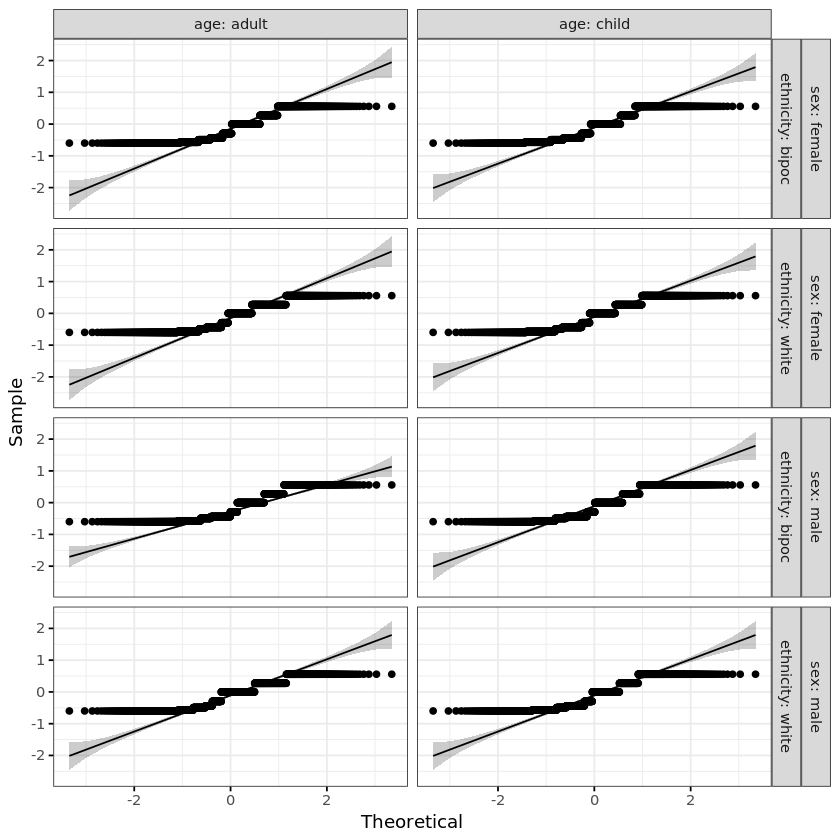

In [21]:
ggqqplot(df, "sentimentScore", ggtheme = theme_bw()) +
  facet_grid(sex + ethnicity ~ age, labeller = "label_both")

**Definetively not normal data**

## Anova 2x2x2 computation 


My design is 2x2x2 fully-crosses, meaning will yield a singular decomposition. 
This is probably why LMER doesn't converge regardless of the optimizer and other hyper-params

Guide: https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/#summary-statistics-2

In [91]:
df

participantId,photoId,emotion,ethnicity,sex,age,label,url,sentimentScore,sexC,ageC,ethnicityC,ID,participantIdF
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
0,Q2.1,Neutral,bipoc,female,adult,anger,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bJXdODAZHOaG0rI,0.0000,-0.5,0.5,-0.5,1,0
0,Q163.1,Happiness,white,male,child,happiness,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_eWnGys8SLE5J3Cu,0.5574,0.5,-0.5,0.5,2,0
0,Q77.1,Disgust,bipoc,male,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_1Zx26VAbwv9uFFQ,-0.5994,0.5,0.5,-0.5,3,0
0,Q78.1,Disgust,bipoc,male,child,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bjzYq2UEKkXH7aC,-0.5994,0.5,-0.5,-0.5,4,0
0,Q162.1,Happiness,white,male,adult,happiness,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_3NR7AkPxBUkdOQe,0.5574,0.5,0.5,0.5,5,0
0,Q79.1,Uncertain,white,female,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_5hkOSrFORUoHopM,-0.2960,-0.5,0.5,0.5,6,0
0,Q130.1,Happiness,white,male,child,uncertain,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_eMb3pnSJgKC0VFk,0.5574,0.5,-0.5,0.5,7,0
0,Q20.1,Fear,bipoc,male,adult,fear,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_54KW05fRgzNmLfE,-0.4939,0.5,0.5,-0.5,8,0
0,Q7.1,Anger,white,female,child,anger,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_1XqAx3FzoRDFZt4,-0.5719,-0.5,-0.5,0.5,9,0


In [96]:
df_long = df %>% select(participantId, sex, age, ethnicity, photoId, sentimentScore)

In [98]:
library(reshape2)

data_wide <- dcast(df_long,sex + age + ethnicity ~ photoId, value.var="sentimentScore")
data_wide

Aggregation function missing: defaulting to length



sex,age,ethnicity,Q10.1,Q100.1,Q101.1,Q102.1,Q103.1,Q104.1,Q105.1,⋯,Q90.1,Q91.1,Q92.1,Q93.1,Q94.1,Q95.1,Q96.1,Q97.1,Q98.1,Q99.1
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
female,adult,bipoc,51,0,0,0,0,0,0,⋯,0,51,0,0,0,0,0,0,0,51
female,adult,white,0,0,0,0,51,0,0,⋯,0,0,0,0,0,51,0,0,0,0
female,child,bipoc,0,51,0,0,0,0,0,⋯,0,0,51,0,0,0,0,0,0,0
female,child,white,0,0,0,0,0,51,0,⋯,0,0,0,0,0,0,51,0,0,0
male,adult,bipoc,0,0,51,0,0,0,0,⋯,0,0,0,51,0,0,0,0,0,0
male,adult,white,0,0,0,0,0,0,51,⋯,0,0,0,0,0,0,0,51,0,0
male,child,bipoc,0,0,0,51,0,0,0,⋯,0,0,0,0,51,0,0,0,0,0
male,child,white,0,0,0,0,0,0,0,⋯,51,0,0,0,0,0,0,0,51,0


In [88]:
df_wide <- spread(df, sex, sentimentScore,)
df_wide

participantId,photoId,emotion,ethnicity,age,label,url,sexC,ageC,ethnicityC,ID,participantIdF,female,male
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>
0,Q2.1,Neutral,bipoc,adult,anger,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bJXdODAZHOaG0rI,-0.5,0.5,-0.5,1,0,0.0000,NA
0,Q163.1,Happiness,white,child,happiness,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_eWnGys8SLE5J3Cu,0.5,-0.5,0.5,2,0,NA,0.5574
0,Q77.1,Disgust,bipoc,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_1Zx26VAbwv9uFFQ,0.5,0.5,-0.5,3,0,NA,-0.5994
0,Q78.1,Disgust,bipoc,child,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bjzYq2UEKkXH7aC,0.5,-0.5,-0.5,4,0,NA,-0.5994
0,Q162.1,Happiness,white,adult,happiness,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_3NR7AkPxBUkdOQe,0.5,0.5,0.5,5,0,NA,0.5574
0,Q79.1,Uncertain,white,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_5hkOSrFORUoHopM,-0.5,0.5,0.5,6,0,-0.2960,NA
0,Q130.1,Happiness,white,child,uncertain,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_eMb3pnSJgKC0VFk,0.5,-0.5,0.5,7,0,NA,0.5574
0,Q20.1,Fear,bipoc,adult,fear,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_54KW05fRgzNmLfE,0.5,0.5,-0.5,8,0,NA,-0.4939
0,Q7.1,Anger,white,child,anger,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_1XqAx3FzoRDFZt4,-0.5,-0.5,0.5,9,0,-0.5719,NA


In [86]:
# res.aov <- anova_test(
#   data = df, dv = sentimentScore, wid = participantId,
#   within = c(sex, age, ethnicity)
#   )
# get_anova_table(res.aov)

In [71]:
res.aov  = ezANOVA(data=df, wid=.(participantId), dv=.(sentimentScore), within=.(sex, age, ethnicity))
res.aov  

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "age" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,50,9.521419,3.306335e-03,*,0.016548360
3,age,1,50,21.604378,2.475379e-05,*,0.054099828
4,ethnicity,1,50,31.530648,8.618142e-07,*,0.051307750
5,sex:age,1,50,2.852944,9.743446e-02,,0.003967705
6,sex:ethnicity,1,50,13.324762,6.258531e-04,*,0.026661649
7,age:ethnicity,1,50,19.737606,4.929783e-05,*,0.025649119
8,sex:age:ethnicity,1,50,5.194152,2.696674e-02,*,0.009402510


## Post-hoc tests

multiple pairwise paired t-tests between the levels of the within-subjects factor

In [65]:
# # Two-way ANOVA at each diet level
# two.way <- df %>%
#   group_by(age) %>%
#   anova_test(dv = sentimentScore, wid = ID, within = c(ethnicity, sex))
# two.way

In [68]:
# Pairwise comparisons
pwc <- df %>%
  group_by(age, sex) %>%
  pairwise_t_test(sentimentScore ~ ethnicity, paired = TRUE, p.adjust.method = "bonferroni") %>%
  select(-df, -statistic) # Remove details
# Show comparison results for "diet:no,exercises:yes" groups
# pwc %>% filter(diet == "no", exercises == "yes") %>%
#   select(-p)     # remove p columns

pwc

sex,age,.y.,group1,group2,n1,n2,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
female,adult,sentimentScore,bipoc,white,1224,1224,3.34e-01,3.34e-01,ns
male,adult,sentimentScore,bipoc,white,1224,1224,8.88e-07,8.88e-07,****
female,child,sentimentScore,bipoc,white,1224,1224,9.87e-01,9.87e-01,ns
male,child,sentimentScore,bipoc,white,1224,1224,2.97e-01,2.97e-01,ns


In [87]:
# # Visualization: box plots with p-values
# pwc <- pwc %>% add_xy_position(x = "sex")

# bxp + 
#   stat_pvalue_manual(pwc, tip.length = 0, hide.ns = TRUE) +
#   labs(
#     subtitle = get_test_label(res.aov, detailed = TRUE),
#     caption = get_pwc_label(pwc)
#   )

## Report

<!-- The **sentiment score** was statistically significantly different for:
- age: F(2, 18) = 55.5, p < 0.0001, generalized eta squared = 0.82.
- sex: F(2, 18) = 55.5, p < 0.0001, generalized eta squared = 0.82.
- ethnicity: F(2, 18) = 55.5, p < 0.0001, generalized eta squared = 0.82.
- sex:ethnicity: F(2, 18) = 55.5, p < 0.0001, generalized eta squared = 0.82.
- age:ethnicity: F(2, 18) = 55.5, p < 0.0001, generalized eta squared = 0.82.
- sex:age:ethnicity: F(2, 18) = 55.5, p < 0.0001, generalized eta squared = 0.82.



Post-hoc analyses with a Bonferroni adjustment revealed that all the pairwise differences, between time points, were statistically significantly different (p <= 0.05).


2	sex 	1	50	9.521419	3.306335e-03	*	0.016548360
3	age 	1	50	21.604378	2.475379e-05	*	0.054099828
4	ethnicity 	1	50	31.530648	8.618142e-07	*	0.051307750
5	sex:age 	1	50	2.852944	9.743446e-02		0.003967705
6	sex:ethnicity 	1	50	13.324762	6.258531e-04	*	0.026661649
7	age:ethnicity 	1	50	19.737606	4.929783e-05	*	0.025649119
8	sex:age:ethnicity	1	50	5.194152	2.696674e-02	*	0.009402510 -->

## Anova agrgegated across ethnicity for between-effect

In [44]:
mDf = aggregate(sentimentScore ~ participantId + ethnicityC, data=df, FUN=mean)

In [45]:
summary(aov(sentimentScore ~ ethnicityC, data=mDf))     # ANOVA with just the between-effect

             Df  Sum Sq  Mean Sq F value   Pr(>F)    
ethnicityC    1 0.02102 0.021020   12.05 0.000764 ***
Residuals   100 0.17436 0.001744                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
# Images depicting caucasian faces 

In [50]:
mDf %>%
  group_by(ethnicityC) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicityC,variable,n,mean,sd
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-0.5,sentimentScore,51,-0.130,0.042
0.5,sentimentScore,51,-0.101,0.041


In [51]:
-0.130 - (-0.101)

[1] -0.029